In [1]:
!pip install timm --quiet

import os
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score
from sklearn.model_selection import StratifiedKFold
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
import random
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.1 MB/s eta 0:00:00:00:0100:01


In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")


Device: cpu
CUDA available: False



DATA LOADING AND EXPLORATION
Training dataset shape: (682, 2)
Columns: ['filename', 'label']

First few rows:
       filename   label
0  39d30b68.jpg  Naeimi
1  4a9853bd.jpg    Goat
2  d88facaa.jpg   Roman
3  a3f4f4af.jpg   Roman
4  16b31730.jpg  Naeimi

Class distribution:
label
Naeimi     255
Goat       107
Sawakni     80
Roman       72
Najdi       71
Harri       62
Barbari     35
Name: count, dtype: int64


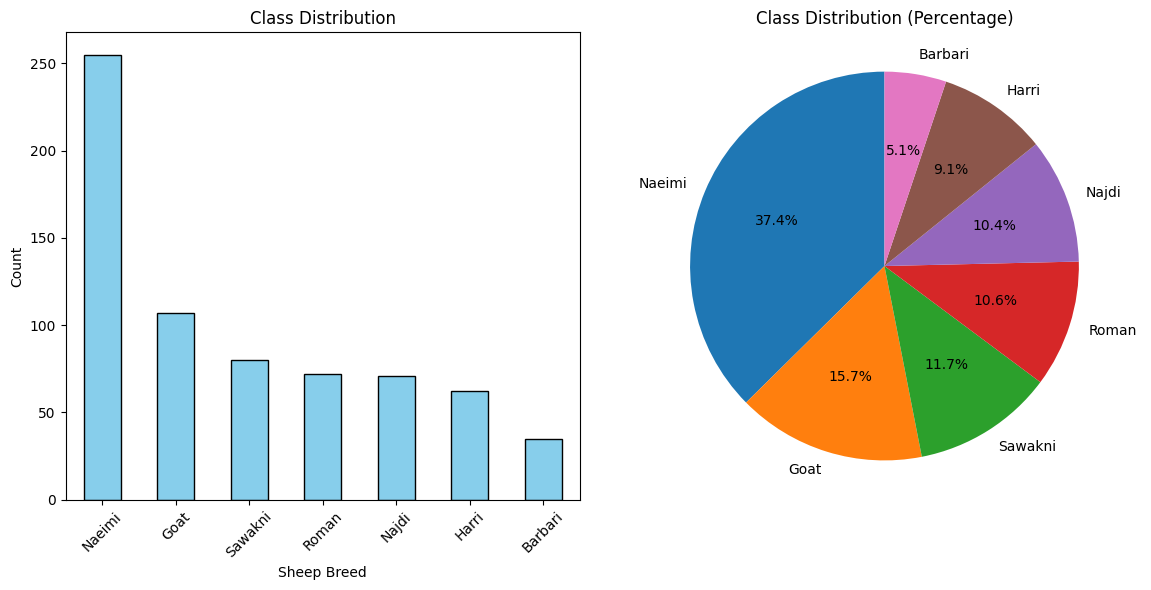


Label mappings: {'Barbari': 0, 'Goat': 1, 'Harri': 2, 'Naeimi': 3, 'Najdi': 4, 'Roman': 5, 'Sawakni': 6}
Number of classes: 7


In [3]:
# ===== DATA LOADING AND EXPLORATION =====
print("\n" + "="*50)
print("DATA LOADING AND EXPLORATION")
print("="*50)

# Load data
train_csv = pd.read_csv('/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train_labels.csv')
train_path = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/train'
test_path = '/kaggle/input/sheep-classification-challenge-2025/Sheep Classification Images/test'

print(f"Training dataset shape: {train_csv.shape}")
print(f"Columns: {train_csv.columns.tolist()}")
print(f"\nFirst few rows:")
print(train_csv.head())

# Check class distribution
print(f"\nClass distribution:")
class_counts = train_csv['label'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Sheep Breed')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution (Percentage)')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Create label mappings
label2idx = {label: idx for idx, label in enumerate(sorted(train_csv['label'].unique()))}
idx2label = {idx: label for label, idx in label2idx.items()}
train_csv['label_idx'] = train_csv['label'].map(label2idx)

print(f"\nLabel mappings: {label2idx}")
print(f"Number of classes: {len(label2idx)}")

In [4]:
# ===== DATA SPLITTING =====
print("\n" + "="*50)
print("DATA SPLITTING")
print("="*50)

# Stratified split to maintain class balance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for train_idx, val_idx in skf.split(train_csv, train_csv['label_idx']):
    train_df = train_csv.iloc[train_idx].reset_index(drop=True)
    val_df = train_csv.iloc[val_idx].reset_index(drop=True)
    break  # Use first split

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

# Check class distribution in splits
print(f"\nTrain set class distribution:")
print(train_df['label'].value_counts())
print(f"\nValidation set class distribution:")
print(val_df['label'].value_counts())


DATA SPLITTING
Train size: 545
Validation size: 137

Train set class distribution:
label
Naeimi     204
Goat        85
Sawakni     64
Roman       58
Najdi       57
Harri       49
Barbari     28
Name: count, dtype: int64

Validation set class distribution:
label
Naeimi     51
Goat       22
Sawakni    16
Roman      14
Najdi      14
Harri      13
Barbari     7
Name: count, dtype: int64


In [7]:
# ===== DATASET CLASS =====
class SheepDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Fixed: Use 'filename' instead of 'image'
        img_path = os.path.join(self.img_dir, row['filename'])
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        label = row['label_idx']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



DATA AUGMENTATION
Visualizing sample augmented images...


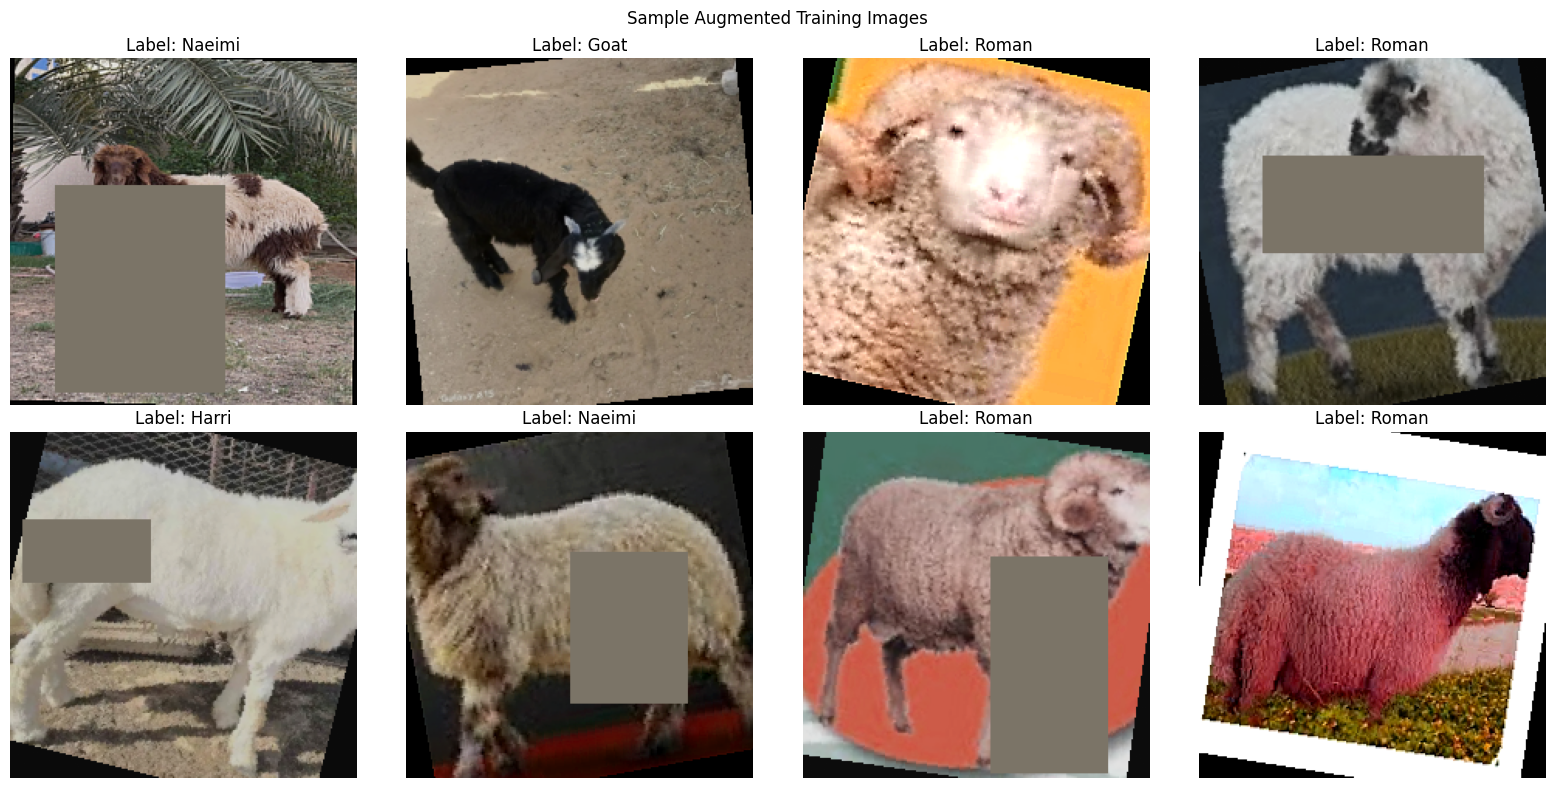

Train batches: 17
Validation batches: 5


In [8]:
# ===== DATA AUGMENTATION =====
print("\n" + "="*50)
print("DATA AUGMENTATION")
print("="*50)

# Enhanced augmentations for better generalization
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = SheepDataset(train_df, train_path, train_transform)
val_dataset = SheepDataset(val_df, train_path, val_transform)

# Visualize sample augmented images
def visualize_augmentations(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(num_samples):
        img, label = dataset[i]
        # Denormalize for visualization
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f'Label: {idx2label[label]}')
        axes[i].axis('off')
    
    plt.suptitle('Sample Augmented Training Images')
    plt.tight_layout()
    plt.show()

print("Visualizing sample augmented images...")
visualize_augmentations(train_dataset)

# Create data loaders
BATCH_SIZE = 32  # Reduced for better stability
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

In [9]:
# ===== MODEL ARCHITECTURE =====
print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)

class SheepClassifier(nn.Module):
    def __init__(self, num_classes, model_name='convnext_base'):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        
        # Get the feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224)
            features = self.backbone(dummy_input)
            feature_dim = features.shape[1]
        
        # Enhanced classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, 512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Create model
model = SheepClassifier(num_classes=len(label2idx), model_name='convnext_base').to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


MODEL ARCHITECTURE


model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

Total parameters: 88,226,439
Trainable parameters: 88,226,439


In [10]:
# ===== TRAINING SETUP =====
print("\n" + "="*50)
print("TRAINING SETUP")
print("="*50)

EPOCHS = 25
LEARNING_RATE = 1e-4

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Learning rate scheduler
steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=LEARNING_RATE, 
                      steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                      pct_start=0.3, div_factor=10, final_div_factor=100)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler() if device.type == 'cuda' else None

print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Mixed precision: {scaler is not None}")


TRAINING SETUP
Epochs: 25
Learning rate: 0.0001
Steps per epoch: 17
Mixed precision: False


In [13]:
# ===== TRAINING FUNCTIONS =====
def train_one_epoch(model, loader, optimizer, criterion, scaler, scheduler, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if batch_idx % 20 == 0:
            print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(loader)}, '
                  f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

def validate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    f1 = f1_score(all_labels, all_preds, average='macro')
    
    return epoch_loss, epoch_acc, f1, np.array(all_labels), np.array(all_preds)


In [14]:
# ===== TRAINING LOOP =====
print("\n" + "="*50)
print("TRAINING")
print("="*50)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_f1 = 0.0
patience = 7
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)
    
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, scheduler, epoch)
    
    # Validation
    val_loss, val_acc, val_f1, val_labels, val_preds = validate_model(model, val_loader, criterion)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")
    
    # Early stopping and model saving
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best F1 score: {best_f1:.4f} - Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {patience} epochs without improvement")
            break

print(f"\nTraining completed! Best F1 score: {best_f1:.4f}")



TRAINING

Epoch 1/25
------------------------------
Epoch 1, Batch 0/17, Loss: 1.9597, Acc: 6.25%
Train Loss: 1.9186, Train Acc: 0.2500
Val Loss: 1.8472, Val Acc: 0.5036, Val F1: 0.3047
New best F1 score: 0.3047 - Model saved!

Epoch 2/25
------------------------------
Epoch 2, Batch 0/17, Loss: 1.8097, Acc: 46.88%
Train Loss: 1.7865, Train Acc: 0.4393
Val Loss: 1.6710, Val Acc: 0.4453, Val F1: 0.2009

Epoch 3/25
------------------------------
Epoch 3, Batch 0/17, Loss: 1.6660, Acc: 50.00%
Train Loss: 1.5736, Train Acc: 0.4908
Val Loss: 1.3952, Val Acc: 0.6496, Val F1: 0.4611
New best F1 score: 0.4611 - Model saved!

Epoch 4/25
------------------------------
Epoch 4, Batch 0/17, Loss: 1.6162, Acc: 46.88%
Train Loss: 1.2486, Train Acc: 0.7114
Val Loss: 1.0230, Val Acc: 0.8321, Val F1: 0.7005
New best F1 score: 0.7005 - Model saved!

Epoch 5/25
------------------------------
Epoch 5, Batch 0/17, Loss: 1.0642, Acc: 75.00%
Train Loss: 0.8939, Train Acc: 0.8768
Val Loss: 0.6865, Val Acc: 0


TRAINING VISUALIZATION


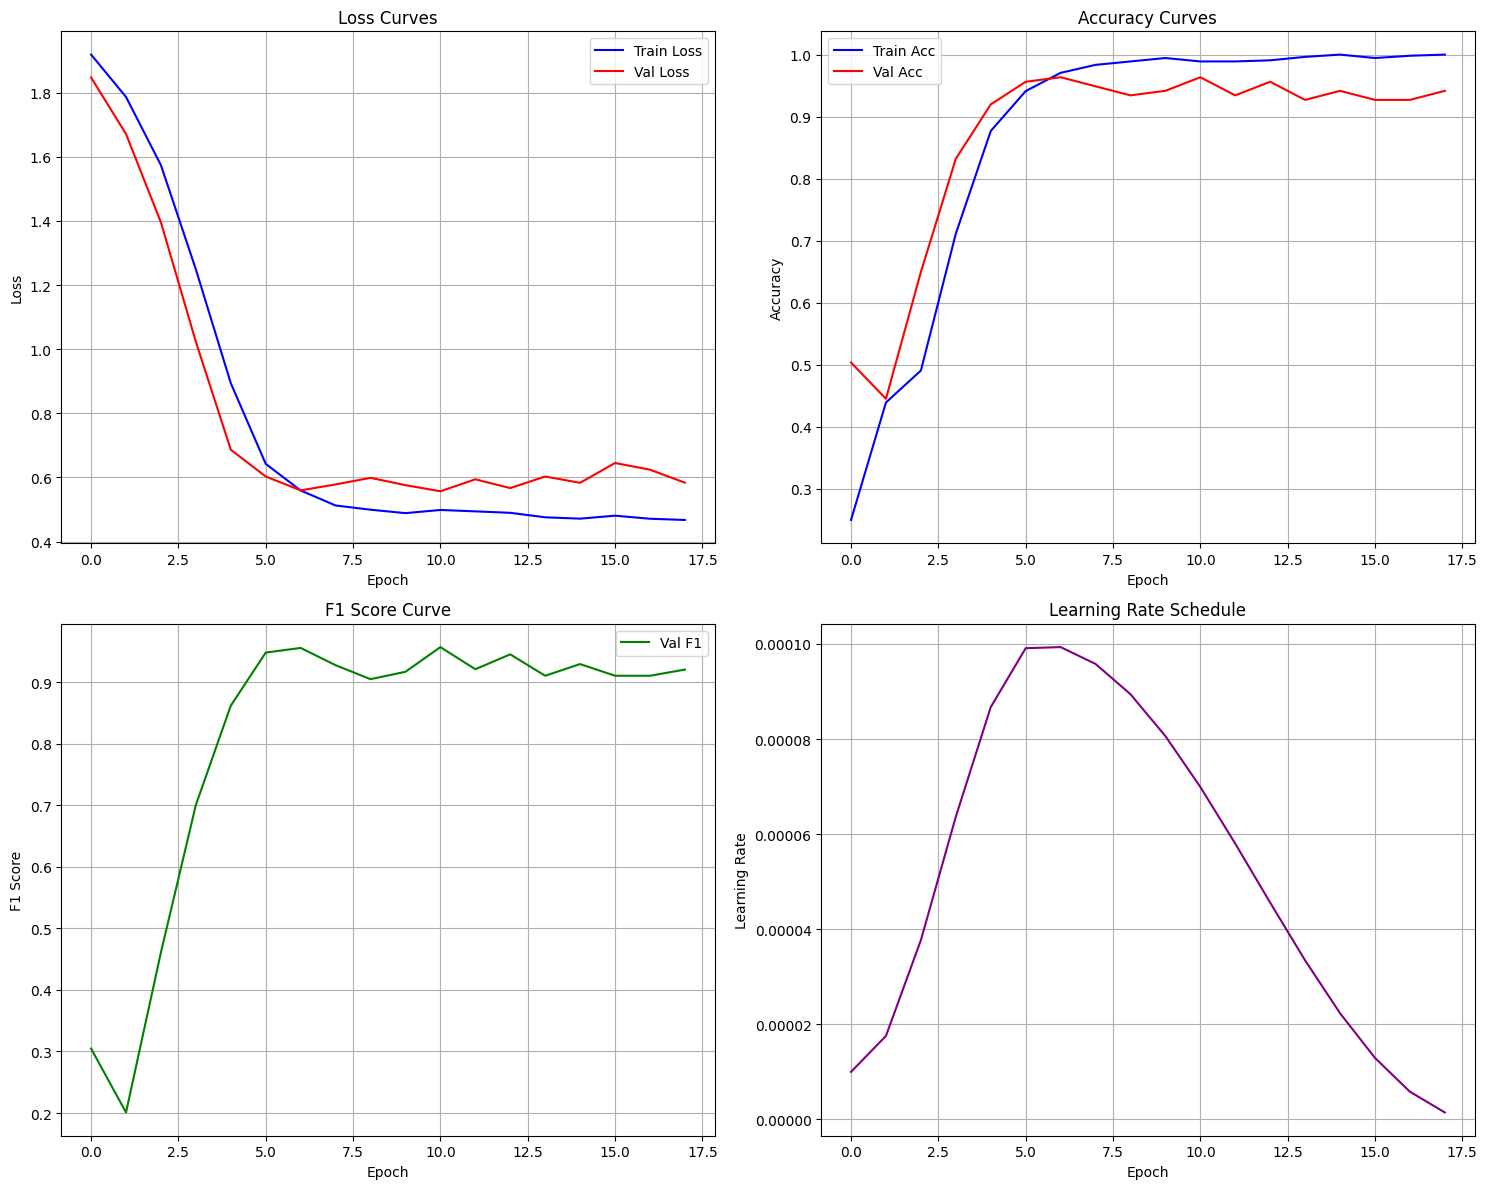

In [15]:
# ===== TRAINING VISUALIZATION =====
print("\n" + "="*50)
print("TRAINING VISUALIZATION")
print("="*50)

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0, 0].plot(history['val_loss'], label='Val Loss', color='red')
axes[0, 0].set_title('Loss Curves')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy curves
axes[0, 1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[0, 1].plot(history['val_acc'], label='Val Acc', color='red')
axes[0, 1].set_title('Accuracy Curves')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1 score curve
axes[1, 0].plot(history['val_f1'], label='Val F1', color='green')
axes[1, 0].set_title('F1 Score Curve')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning rate schedule
lr_history = []
temp_optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
temp_scheduler = OneCycleLR(temp_optimizer, max_lr=LEARNING_RATE, 
                           steps_per_epoch=steps_per_epoch, epochs=len(history['train_loss']), 
                           pct_start=0.3, div_factor=10, final_div_factor=100)

for _ in range(len(history['train_loss']) * steps_per_epoch):
    lr_history.append(temp_scheduler.get_last_lr()[0])
    temp_scheduler.step()

epoch_lr = [lr_history[i * steps_per_epoch] for i in range(len(history['train_loss']))]
axes[1, 1].plot(epoch_lr, color='purple')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


MODEL EVALUATION
Final Validation Results:
Accuracy: 0.9635
F1 Score (Macro): 0.9569

Detailed Classification Report:
              precision    recall  f1-score   support

     Barbari       0.88      1.00      0.93         7
        Goat       0.96      1.00      0.98        22
       Harri       1.00      0.92      0.96        13
      Naeimi       0.96      0.98      0.97        51
       Najdi       1.00      1.00      1.00        14
       Roman       0.92      0.86      0.89        14
     Sawakni       1.00      0.94      0.97        16

    accuracy                           0.96       137
   macro avg       0.96      0.96      0.96       137
weighted avg       0.96      0.96      0.96       137



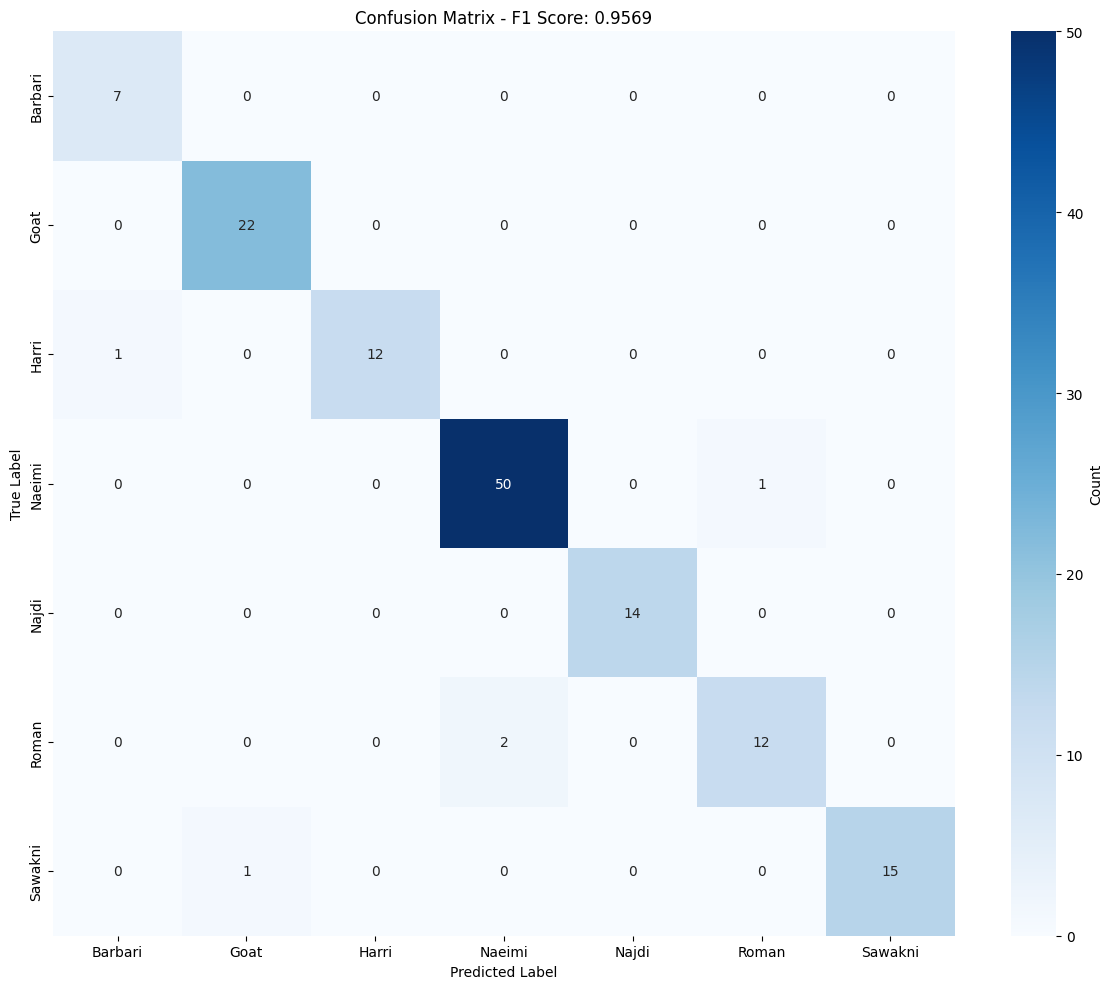

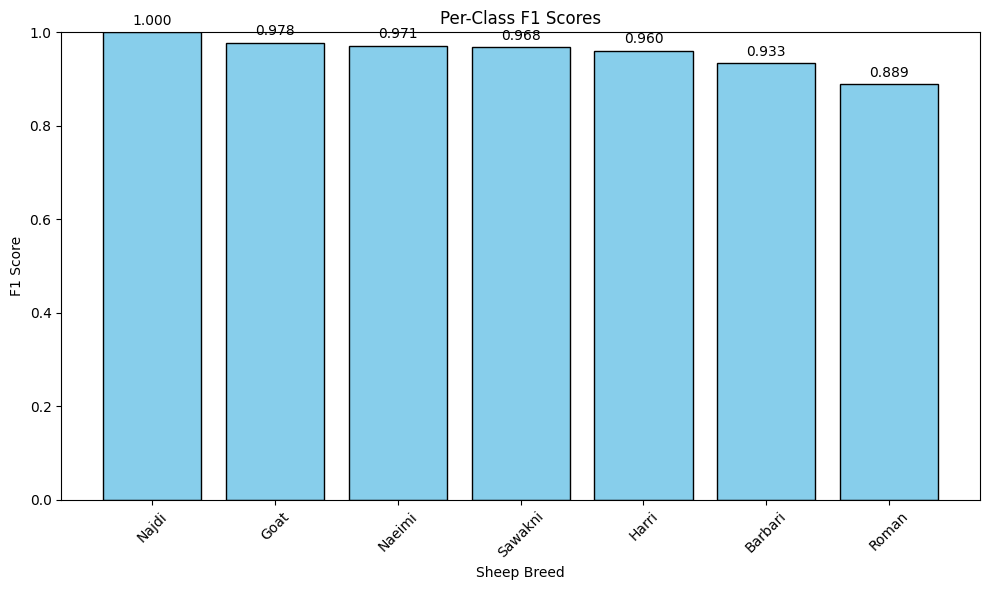


Per-class F1 scores:
Najdi: 1.0000
Goat: 0.9778
Naeimi: 0.9709
Sawakni: 0.9677
Harri: 0.9600
Barbari: 0.9333
Roman: 0.8889


In [16]:
# ===== MODEL EVALUATION =====
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Final validation
val_loss, val_acc, val_f1, val_labels, val_preds = validate_model(model, val_loader, criterion)

print(f"Final Validation Results:")
print(f"Accuracy: {val_acc:.4f}")
print(f"F1 Score (Macro): {val_f1:.4f}")

# Classification report
print(f"\nDetailed Classification Report:")
print(classification_report(val_labels, val_preds, target_names=list(label2idx.keys())))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(val_labels, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label2idx.keys()), 
            yticklabels=list(label2idx.keys()),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix - F1 Score: {val_f1:.4f}')
plt.tight_layout()
plt.show()

# Per-class F1 scores
per_class_f1 = f1_score(val_labels, val_preds, average=None)
f1_df = pd.DataFrame({
    'Class': list(label2idx.keys()),
    'F1_Score': per_class_f1
}).sort_values('F1_Score', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(f1_df['Class'], f1_df['F1_Score'], color='skyblue', edgecolor='black')
plt.xlabel('Sheep Breed')
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Scores')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, score in zip(bars, f1_df['F1_Score']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nPer-class F1 scores:")
for _, row in f1_df.iterrows():
    print(f"{row['Class']}: {row['F1_Score']:.4f}")


In [17]:
# ===== TEST PREDICTION =====
print("\n" + "="*50)
print("TEST PREDICTION")
print("="*50)

class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading test image {img_path}: {e}")
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.img_files[idx]

# Create test dataset and loader
test_dataset = TestDataset(test_path, val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Test images: {len(test_dataset)}")

# Make predictions
model.eval()
test_predictions = []
test_filenames = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(images)
        else:
            outputs = model(images)
        
        _, predicted = outputs.max(1)
        test_predictions.extend(predicted.cpu().numpy())
        test_filenames.extend(filenames)

# Create submission file
submission = pd.DataFrame({
    'filename': test_filenames,
    'label': [idx2label[idx] for idx in test_predictions]
})

# Display submission statistics
print(f"\nSubmission Statistics:")
print(submission['label'].value_counts())

# Save submission
submission.to_csv('submission.csv', index=False)
print(f"\nSubmission saved to 'submission.csv'")
print(f"Submission shape: {submission.shape}")
print(f"\nFirst few predictions:")
print(submission.head(10))

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Best F1 Score: {best_f1:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Submission file created: submission.csv")
print("="*50)


TEST PREDICTION
Test images: 144

Submission Statistics:
label
Goat       41
Roman      32
Sawakni    21
Naeimi     16
Najdi      16
Barbari    12
Harri       6
Name: count, dtype: int64

Submission saved to 'submission.csv'
Submission shape: (144, 2)

First few predictions:
       filename    label
0  0306fa89.jpg  Barbari
1  0345e3ca.jpg    Roman
2  0551a473.jpg  Sawakni
3  06e1783d.jpg     Goat
4  08b9981b.jpg  Barbari
5  0cfc6a1e.jpg     Goat
6  100bd43a.jpg    Roman
7  1081d46a.jpg   Naeimi
8  10e27bf7.jpg    Roman
9  11bc3308.jpg  Sawakni

TRAINING COMPLETE!
Best F1 Score: 0.9569
Final Validation Accuracy: 0.9635
Submission file created: submission.csv
